In [1]:
%matplotlib inline
import time
import random
from random import shuffle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import itertools
import logging

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import CIFAR10

from scipy.stats import entropy, ks_2samp
from scipy.special import kl_div
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import label_binarize

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import traceback
import copy
import os

In [2]:
logname = 'logs/decentralized_multi_agent'
logging.basicConfig(filename=logname,
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)

logging.info("Running Decentralized Learning test")

logger = logging.getLogger('Decentralized_log')

In [3]:
# reproduce randomness for fair comparison
np.random.seed(0)
torch.manual_seed(3)

In [4]:
brain_df = pd.read_csv('../data/brain_tumor.csv',usecols=[0,1])
brain_df.head()

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


In [5]:
brain_df['Class'].value_counts()

0    2079
1    1683
Name: Class, dtype: int64

In [6]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, x, y, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.y = y
        self.all_imgs = x
#         self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx]+'.jpg')
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image,self.y[idx]

In [7]:
# If we are saving a fraction of random data to be used in training
test_frac = int(len(brain_df.Image) * 0.19)
frac1 = int(len(brain_df.Image) * 0.46)
frac2 = int(len(brain_df.Image) * 0.73)

x_train1 = np.array(brain_df.iloc[test_frac:frac1].Image)
y_train1 = np.array(brain_df.iloc[test_frac:frac1].Class)
x_train2 = np.array(brain_df.iloc[frac1:frac2].Image)
y_train2 = np.array(brain_df.iloc[frac1:frac2].Class)
x_train3 = np.array(brain_df.iloc[frac2:].Image)
y_train3 = np.array(brain_df.iloc[frac2:].Class)

x_test = np.array(brain_df.iloc[:test_frac].Image)
y_test = np.array(brain_df.iloc[:test_frac].Class)

In [8]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
# train_data = datasets.ImageFolder('../data/brain_tumor_images/', transform=transform)

trainset1 = CustomDataSet('../data/brain_tumor_images/brain_tumor/',x=x_train1,y=y_train1, transform=transform)
trainset2 = CustomDataSet('../data/brain_tumor_images/brain_tumor/',x=x_train2,y=y_train2, transform=transform)
trainset3 = CustomDataSet('../data/brain_tumor_images/brain_tumor/',x=x_train3,y=y_train3, transform=transform)
testset = CustomDataSet('../data/brain_tumor_images/brain_tumor/',x=x_test,y=y_test, transform=transform)

In [9]:
train_loader1 = DataLoader(trainset1 , batch_size=16, shuffle=True, num_workers=1, drop_last=False)
train_loader2 = DataLoader(trainset2 , batch_size=16, shuffle=True, num_workers=1, drop_last=False)
train_loader3 = DataLoader(trainset3 , batch_size=16, shuffle=True, num_workers=1, drop_last=False)
test_loader = DataLoader(testset , batch_size=16, shuffle=True, num_workers=1, drop_last=False)

In [10]:
def imshow(img):
    img = img / 2 + 0.3    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#### Test that things are working

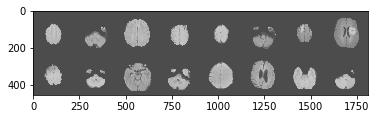

In [11]:
img, label = next(iter(train_loader1))
imshow(torchvision.utils.make_grid(img))

#### Decide on a GPU to use

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
# device = 'cpu'
print(device)

# device2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

cuda:0


# Decentralized Pairwise Knowledge Transfer

## Define models used in knowledge transfer

In [13]:
def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear)):
        torch.nn.init.sparse_(m.weight, sparsity=0.33)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.Conv2d)):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Decenter(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter, self).__init__()
        if len(shape) == 1:
            shape = shape[0]
            self.dim = 0
        elif len(shape) == 2:
            shape = shape[1]
            self.dim = 1
        self.translation = torch.nn.Sequential(
#             torch.nn.Tanh(),
            torch.nn.Linear(shape*3, shape)
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), self.dim)
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(target.shape)
        return res
    
    
class Interpolate(torch.nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = torch.nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=False)
        return x
    
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Decenter_pooled(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_pooled, self).__init__()
        self.shape = shape
        self.translation = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(channels_out),
#             torch.nn.AdaptiveAvgPool2d(1),
            Interpolate(size=1, mode='bilinear'),
            Reshape(shape[0], shape[1]*2),
            torch.nn.Linear(shape[1]*2, shape[1]*shape[-1]*shape[-1]),
#             Reshape(shape[0], shape[1] ,1 ,1),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), 1)
        res = self.translation(x)
        res = res.view(self.shape[0], self.shape[1], self.shape[2], self.shape[3])
        return res
    
    
class Decenter_conv(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_conv, self).__init__()
        self.shape = shape
        channels_in = shape[1]*3
        channels_out = shape[1]
        self.translation = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channels_in),
            torch.nn.Conv2d(channels_in, channels_out, 3, stride=1, padding=1)
#             torch.nn.ConvTranspose2d(channels_in, channels_out, 3, stride=1, padding=1)
#             torch.nn.Linear(shape[0]*2, shape[0]*4),
#             torch.nn.Dropout(p=0.5),
#             torch.nn.Linear(shape[0]*2, shape[0]),
#             torch.nn.AdaptiveAvgPool2d((shape[-2],shape[-1])),
#             torch.nn.Conv2d(channels_out, channels_out, 3, stride=1, padding=1)

        )
        self.translation2 = torch.nn.Sequential(
            torch.nn.AdaptiveMaxPool2d((shape[-2],shape[-1])),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), 1)
#         x = x.reshape(-1, x.shape[0])
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(self.shape)
        return res

## Define the local training process

In [14]:
### Hooks are used to investigate the effect of gradiant decent on weights. Not necessary for simply reproducing paper results. 
grad_dict: dict = {}
def fc_hook(layer_name, grad_input, grad_output): 
    if layer_name not in grad_dict:
        grad_dict[layer_name] = {}
        grad_dict[layer_name]["grad_input"] = []
        grad_dict[layer_name]["grad_output"] = []
        grad_dict[layer_name]["labels"] = []
        
#     print(grad_input)
#     print(grad_output)
    grad_dict[layer_name]["grad_input"].append(grad_input[0].cpu().numpy())
    grad_dict[layer_name]["grad_output"].append(grad_output[0].cpu().numpy())
    
# def reserve_step(source, target):
    

matlst = []
fclst = []

## Option are used for simulating remote agents using pairwise knowledge transfer 
options = {0: ['trainA', 'validA','reservedAB'], 
           1: ['trainB','validB','reservedBA'],
           2: ['trainC','validC','reservedCA','validC']}

def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    writer = SummaryWriter('runs/') 

    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = 0.0
    best_acc = 0.0
    dataset_sizes = {'trainA': len(dataloders['trainA'].sampler),
                     'trainB': len(dataloders['trainB'].sampler),
                     'trainC': len(dataloders['trainC'].sampler),
                     'ABtoC': len(dataloders['ABtoC'].sampler),
                     'validA': len(dataloders['validA'].sampler),
                     'validB': len(dataloders['validB'].sampler),
                     'validC': len(dataloders['validC'].sampler)}

    i = 0
    ivc = 0
    for epoch in range(num_epochs):
        for phase in ['trainA', 'validA','trainB','validB','trainC','validC','ABtoC','validC']:  ## this sequense simualtes a half mesh configuation
#         choice = np.random.choice(range(3), replace=False)
#         for phase in options[choice]:
            if phase not in ['validA','validB','validC']:
                model[phase].train(True)
            else:
                model['trainA'].train(False)
                model['trainB'].train(False)
                model['trainC'].train(False)
            
            
            running_loss = 0.0
            running_corrects = 0
            
            ## if its a transfer phase, swap layers using the pipline models
            if phase in ['ABtoC']:
                if phase == 'ABtoC':
                    sd = model[phase].state_dict()
                    for key, value in mdlzAC.items():
                        shape = model['trainC'].state_dict()[key].shape
                        mdl = value[1](shape).to(device)
                        checkpoint = torch.load(value[0])
                        mdl.load_state_dict(checkpoint['model_state_dict'])
                        mdl.eval()
                        sd[key] = mdl(copy.deepcopy(model['trainA'].state_dict()[key]),
                                      copy.deepcopy(model['trainB'].state_dict()[key]),
                                      copy.deepcopy(model['trainC'].state_dict()[key]))
#                         torch.save({'model_state_dict': mdl.state_dict()}, value[0])
                        
#                         if key == 'conv1.weight':
#                             matlst.append(sd[key])
#                         elif key == 'fc.weight':
#                             fclst.append(sd[key])
                    model[phase].load_state_dict(sd)            
                    
            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer[phase].zero_grad()

                outputs = model[phase](inputs)
                _, preds = torch.max(outputs.data, 1)
                
                ## if its a transfer phase, compute remote loss term
                if phase in ['ABtoC']:
                    loss_a = criterion['trainC'](outputs, labels)
#                     batch_size = labels.shape[0]
#                     # Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
#                     y = labels.reshape(-1,1)
#                     # One hot encoding buffer that you create out of the loop and just keep reusing
#                     y_onehot = torch.FloatTensor(batch_size, 10).to(device)

#                     # In your for loop
#                     y_onehot.zero_()
#                     y_onehot.scatter_(1, y, 1)

                    if phase == 'ABtoC':
                        outputs2 = model['trainA'](inputs)
                        outputs3 = model['trainB'](inputs)
    
                    sm = torch.nn.Softmax(dim=1)
                    outputs = sm(outputs)
                    outputs2 = sm(outputs2)
                    outputs3 = sm(outputs3)
                    loss_b = criterion[phase](outputs, outputs2)
                    loss_c = criterion[phase](outputs, outputs3)
                    loss = (loss_a + (loss_b + loss_c)/2)/2
                    
                ## if its not a transfer phase, compute local loss term
                else:
                    loss = criterion[phase](outputs, labels)

                ## if its not a validation phase, optimize our models
                if phase not in ['validA','validB','validC']:
                    loss.backward()
                    optimizer[phase].step()
                    
                    if phase == 'ABtoC':
#                         loss_b.backward(retain_graph=False)
                        for key, value in mdlzAC.items():
                            shape = model['trainC'].state_dict()[key].shape
                            mdl = value[1](shape).to(device)
                            opti = torch.optim.AdamW(mdl.parameters(), lr=0.1, betas=(0.9, 0.999))
                            checkpoint = torch.load(value[0])
                            mdl.load_state_dict(checkpoint['model_state_dict'])
                            mdl.train(True)
                            opti.load_state_dict(checkpoint['optimizer_state_dict'])
#                             opti.zero_grad()
                            opti.step()
                            torch.save({'model_state_dict': mdl.state_dict(),
                                        'optimizer_state_dict': opti.state_dict(),
                                        'factor': checkpoint['factor'],
                                        'patience': checkpoint['patience'],
                                        'scheduler_state_dict': checkpoint['scheduler_state_dict']},
                                        value[0])
                            
                    
                    ## Back prop hook
#                     grad_dict["fc"]["labels"].append(labels.cpu().numpy())

                
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            ## update scheduler for each model
            if phase in ['validA','validB','validC']:
                scheduler[phase].step(running_loss)
                
            elif phase == 'ABtoC':
                for key, value in mdlzAC.items():
                    checkpoint = torch.load(value[0])
                    sched = lr_scheduler.ReduceLROnPlateau(optimizerC, 'min', factor=checkpoint['factor'], patience=checkpoint['patience'])
                    sched.load_state_dict(checkpoint['scheduler_state_dict'])
                    sched.step(running_loss)
                    torch.save({'model_state_dict': checkpoint['model_state_dict'],
                                'optimizer_state_dict': checkpoint['optimizer_state_dict'],
                                'factor': checkpoint['factor'],
                                'patience': checkpoint['patience'],
                                'scheduler_state_dict': sched.state_dict()},
                                value[0])
                
            ## report results
            if phase not in ['validA','validB','validC']:
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                print() 
                logger.info('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                
                ## Writing to tensorboard
#                 if phase == 'validC':
#                     ivc += 1
#                     if ivc == 2:
#                         writer.add_histogram('distribution centers/our_full_mesh', outputs, i)

#                         writer.add_scalar('train/loss_our_full_mesh', train_epoch_loss, epoch)
#                         writer.add_scalar('train/accuracy_our_full_mesh', train_epoch_acc, epoch)

#                         writer.add_scalar('valid/loss_our_full_mesh', valid_epoch_loss, epoch)
#                         writer.add_scalar('valid/accuracy_our_full_mesh', valid_epoch_acc, epoch)
#                         ivc = 0

                
            if phase in ['validA','validB','validC'] and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model[phase].state_dict()

            i+=1
    print('Best val Acc: {:4f}'.format(best_acc))
    logger.info('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
#     model.load_state_dict(best_model_wts)
    return model

In [35]:
## Define models for network of learners, optimizers, and loss terms

resnetA = models.resnet18(pretrained=False)
resnetB = models.resnet18(pretrained=False)
resnetC = models.resnet18(pretrained=False)
# freeze all model parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# new final layer with 2 classes
num_ftrsA = resnetA.fc.in_features
resnetA.fc = torch.nn.Linear(num_ftrsA, 2)

num_ftrsB = resnetB.fc.in_features
resnetB.fc = torch.nn.Linear(num_ftrsB, 2)

num_ftrsC = resnetC.fc.in_features
resnetC.fc = torch.nn.Linear(num_ftrsC, 2)

def fc_backward_hook(module, grad_input, grad_output):  # module is Linear in this case. Ignored.
        fc_hook("fc", grad_input, grad_output)
resnetA.fc_hook_handle = resnetA.fc.register_backward_hook(fc_backward_hook)
resnetB.fc_hook_handle = resnetB.fc.register_backward_hook(fc_backward_hook)
resnetC.fc_hook_handle = resnetC.fc.register_backward_hook(fc_backward_hook)


def roc_auc_score_micro(y_pred_proba, y_true):
    y_pred_proba = y_pred_proba.detach().cpu()
    y_true = y_true.detach().cpu()
    return metrics.roc_auc_score(
        label_binarize(y_true, classes=list(range(y_pred_proba.shape[1]))).ravel(),
        y_pred_proba.flatten())


resnetA = resnetA.to(device)
resnetB = resnetB.to(device)
resnetC = resnetC.to(device)

criterionA = torch.nn.CrossEntropyLoss()
# criterionB = torch.nn.CrossEntropyLoss()
# criterionA = torch.nn.KLDivLoss()
criterionB = torch.nn.KLDivLoss(reduction = 'batchmean')
# criterionB = torch.nn.KLDivLoss(reduction = 'mean')
# criterionB = torch.nn.MSELoss()
optimizerA = torch.optim.SGD(resnetA.parameters(), lr=0.0001, momentum=0.9)
optimizerB = torch.optim.SGD(resnetB.parameters(), lr=0.0001, momentum=0.9)
optimizerC = torch.optim.SGD(resnetC.parameters(), lr=0.0001, momentum=0.9)
# optimizerA = torch.optim.AdamW(resnetA.parameters(), lr=0.001, betas=(0.9, 0.999))
# optimizerB = torch.optim.AdamW(resnetB.parameters(), lr=0.001, betas=(0.9, 0.999))
# optimizerC = torch.optim.AdamW(resnetC.parameters(), lr=0.001, betas=(0.9, 0.999))

# exp_lr_schedulerA = lr_scheduler.StepLR(optimizerA, step_size=5, gamma=0.01)
# exp_lr_schedulerB = lr_scheduler.StepLR(optimizerB, step_size=5, gamma=0.01)
# exp_lr_schedulerC = lr_scheduler.StepLR(optimizerC, step_size=5, gamma=0.2)
exp_lr_schedulerA = lr_scheduler.ReduceLROnPlateau(optimizerA, 'min', factor=0.90, patience=500)
exp_lr_schedulerB = lr_scheduler.ReduceLROnPlateau(optimizerB, 'min', factor=0.90, patience=500)
exp_lr_schedulerC = lr_scheduler.ReduceLROnPlateau(optimizerC, 'min', factor=0.90, patience=500)


def hwout(Hin, padding, dilation, kernel_size, stride):
    return (Hin + 2 * padding - dilation * (kernel_size-1) - 1)/stride + 1

In [22]:
## Function for finding largest layer

max_layer = 0
max_neurons = 0
for prm in resnetC.named_parameters():
    num_ftr = np.prod(prm[1].shape)
    if num_ftr > max_neurons:
         max_neurons = num_ftr
         max_layer = prm[1]

In [17]:
[x[0] for x in resnetC.named_parameters()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.downsample.0.weight',
 'layer2.0.downsample.1.weight',
 'layer2.0.downsample.1.bias',
 'layer2.1.conv1.weight',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer3.0.conv1.weight',
 'layer3.0.bn1.weight',
 'layer3.0.bn1.bias',
 'layer3.0.conv2.weight',
 'layer3.0.bn2.weight',
 'layer3.0.bn2.bias',
 'layer3.0.downsample.0.weight',
 'layer3.0.downsample.1.weight',
 'layer3.0.downsample.1.bias',
 'layer3.1.conv1.weight',
 'layer3.1.bn1.

In [36]:
# %%timeit
### Define our transfer pipeline and attach models, and parameters. Model chains are saved to disk for memory efficient execution.
mdlzAC = dict()
mdlzAB = dict()
mdlzBA = dict()
params = []
model_dir = './multi_model_chain'
conv_layers = ['layer4.1.conv1.weight', 'layer4.0.conv1.weight']
bn_layers = ['fc.weight']

for prm in resnetC.named_parameters():
# for prm in temp_list:
#     if 'conv' in prm[0] or 'fc' in prm[0] or 'bn' in prm[0] or 'downsample' in prm[0]:
    if prm[0] in bn_layers+conv_layers:
        try:
            if prm[1].dim() > 2:
#                 if prm[0] not in conv_layers:
#                     continue
                mdl = Decenter_conv(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.1, betas=(0.9, 0.999))
                exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.1,
                            'patience': 5,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'A')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.1,
                            'patience': 5,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'B')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.1,
                            'patience': 5,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'C')
                mdlzAC[prm[0]] = (model_dir + '/' + prm[0]+'A', Decenter_conv)
                mdlzAB[prm[0]] = (model_dir + '/' + prm[0]+'B', Decenter_conv)
                mdlzBA[prm[0]] = (model_dir + '/' + prm[0]+'C', Decenter_conv)
#                 params += mdl.parameters()
#                 pass
            else:
#                 if prm[0] not in bn_layers:
#                     continue
                mdl = Decenter(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.1, betas=(0.9, 0.999))
                exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.5,
                            'patience': 1,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'A')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.5,
                            'patience': 1,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'B')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.5,
                            'patience': 1,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'C')
                mdlzAC[prm[0]] = (model_dir + '/' + prm[0]+'A', Decenter)
                mdlzAB[prm[0]] = (model_dir + '/' + prm[0]+'B', Decenter)
                mdlzBA[prm[0]] = (model_dir + '/' + prm[0]+'C', Decenter)
#                 params += mdl.parameters()
            
            del mdl
            torch.cuda.empty_cache()
        except Exception as e:
            print("Problem with: " + prm[0] + " Size: " + str(num_ftr))
            print("Error: " + str(e))
            traceback.print_exc()
            print()
            pass
        
# params += list(resnetC.parameters())

# optimizerRB = torch.optim.SGD(params, lr=0.01, momentum=0.9)
optimizerRC = torch.optim.AdamW(resnetC.parameters(), lr=0.001, betas=(0.9, 0.999))

In [37]:
mdlzAC

{'layer4.0.conv1.weight': ('./multi_model_chain/layer4.0.conv1.weightA',
  __main__.Decenter_conv),
 'layer4.1.conv1.weight': ('./multi_model_chain/layer4.1.conv1.weightA',
  __main__.Decenter_conv),
 'fc.weight': ('./multi_model_chain/fc.weightA', __main__.Decenter)}

In [38]:
### Define phases and associated pareameters
dloaders = {'trainA':train_loader1, 'trainB':train_loader2,'trainC':train_loader3,
            'validA':test_loader, 'validB':test_loader,'validC':test_loader,
            'ABtoC':train_loader3}
model = {'trainA':resnetA, 'trainB':resnetB,'trainC':resnetC,
         'validA':resnetA, 'validB':resnetB,'validC':resnetC,
         'ABtoC':resnetC}
optimizer = {'trainA':optimizerA, 'trainB':optimizerB,'trainC':optimizerC,
             'validA':optimizerA, 'validB':optimizerB,'validC':optimizerC,
             'ABtoC':optimizerB}
criterion = {'trainA':criterionA, 'trainB':criterionA,'trainC':criterionA,
             'validA':criterionA, 'validB':criterionA,'validC':criterionA,
             'ABtoC':criterionB}
exp_lr_scheduler = {'trainA':exp_lr_schedulerA, 'trainB':exp_lr_schedulerB, 'trainC':exp_lr_schedulerC,
             'validA':exp_lr_schedulerA, 'validB':exp_lr_schedulerB, 'validC':exp_lr_schedulerC,
             'ABtoC':exp_lr_schedulerC}

In [39]:
### Run decentralized pairwised knowledge transfer

logging.info("#### bn acti conv and fc - unlimited bn - adam learning rate 0.001 - scheduler 20 - opt adamw ####")

start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/9] phase: validA train loss: 0.0355 acc: 0.6762 valid loss: 0.0355 acc: 0.7101

Epoch [0/9] phase: validB train loss: 0.0382 acc: 0.7067 valid loss: 0.0444 acc: 0.4566

Epoch [0/9] phase: validC train loss: 0.0398 acc: 0.6585 valid loss: 0.0575 acc: 0.2969

Epoch [0/9] phase: validC train loss: -0.0146 acc: 0.3661 valid loss: 0.0417 acc: 0.6835

Epoch [1/9] phase: validA train loss: 0.0304 acc: 0.7717 valid loss: 0.0277 acc: 0.7815

Epoch [1/9] phase: validB train loss: 0.0323 acc: 0.7726 valid loss: 0.0315 acc: 0.7843

Epoch [1/9] phase: validC train loss: 0.0376 acc: 0.6624 valid loss: 0.0388 acc: 0.7269

Epoch [1/9] phase: validC train loss: -0.0159 acc: 0.7451 valid loss: 0.0364 acc: 0.8782

Epoch [2/9] phase: validA train loss: 0.0274 acc: 0.8327 valid loss: 0.0251 acc: 0.8291

Epoch [2/9] phase: validB train loss: 0.0302 acc: 0.7884 valid loss: 0.0270 acc: 0.8263

Epoch [2/9] phase: validC train loss: 0.0308 acc: 0.7953 valid loss: 0.0302 acc: 0.8739

Epoch [2/9] phase: 

## Testing ground - Generate confusion matrices of TP,FP,FN

#### without 5%

In [40]:
confusion_matrix = torch.zeros(2, 2)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [41]:
print(confusion_matrix)

tensor([[491.,  11.],
        [ 56., 156.]])


#### with 5%

In [33]:
confusion_matrix = torch.zeros(2, 2)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [34]:
print(confusion_matrix)

tensor([[483.,  19.],
        [ 27., 185.]])


### with knowledge transfer

In [18]:
confusion_matrix = torch.zeros(10, 10)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [19]:
print(confusion_matrix)

tensor([[705.,   4.,  45.,   4.,  15.,   1.,  17.,  18., 107.,  84.],
        [ 16., 693.,   3.,   0.,   0.,   4.,  12.,   3.,  46., 223.],
        [ 70.,   0., 589.,  25.,  86.,  40.,  90.,  52.,  24.,  24.],
        [ 21.,   1.,  53., 459.,  53., 139., 124.,  83.,  25.,  42.],
        [ 23.,   1.,  57.,  32., 678.,  22.,  70.,  94.,  20.,   3.],
        [  9.,   2.,  42., 146.,  27., 599.,  46.,  99.,   9.,  21.],
        [  3.,   2.,  16.,   7.,   6.,   6., 946.,   4.,   4.,   6.],
        [  4.,   0.,   4.,  13.,  28.,  13.,   9., 916.,   1.,  12.],
        [ 21.,   4.,   3.,   1.,   1.,   0.,   6.,   2., 952.,  10.],
        [  8.,  21.,   1.,   3.,   0.,   1.,   3.,   3.,  21., 939.]])
